In [43]:
import scipy

from scipy.special import expit

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, 

# Construct logistic regression data

In [135]:
n, p = int(1e5), 100
num_significant = 10

In [225]:
A = np.random.uniform(-1, 1, size=(p,p))
cov = A.T @ A

In [228]:
# X = np.random.normal(size=(n, p))
X = np.random.multivariate_normal(np.zeros(p), cov, n)

In [229]:
X.shape

(100000, 100)

In [4]:
beta = np.zeros(p)
beta[:num_significant] = np.random.normal(size=num_significant)

In [230]:
y = np.random.binomial(1, expit(X @ beta)).astype(float)

# Fit Lasso Logistic Regression

In [23]:
# C = 1/lambda
logistic = LogisticRegression(penalty='l1', C=.1)

In [24]:
logistic.fit(X, y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-10,
          verbose=0, warm_start=False)

In [45]:
fit_coeffs = logistic.coef_.flatten()

In [46]:
mean_squared_error(beta, fit_coeffs)

8.7992704812384597e-05

In [51]:
mean_squared_error(expit(X @ beta), expit(X @ fit_coeffs))

0.0001811801097654506

In [56]:
len(set(range(num_significant)) ^ 
    set([i for i, val in enumerate(fit_coeffs) if abs(val) > 1e-3]))

27

## Run for Cartesian products of hyperparameters

In [231]:
def get_lasso_stats(X, y, lam=.1):
    n, p = X.shape
    small_beta = beta[:p]
    logistic = LogisticRegression(penalty='l1', C=1/lam*n)
    logistic.fit(X, y)
    fit_coeffs = logistic.coef_.flatten()
    
    res = {}
    
    res['p'] = p
    res['n'] = n
    res['lam'] = lam
    res['algo'] = 'lasso'
    res['beta_sum_sq'] = sum((small_beta - fit_coeffs)**2)
    res['y_rmse'] = mean_squared_error(expit(X @ small_beta), expit(X @ fit_coeffs))
    res['symm_diff'] = len(set(range(num_significant)) ^ 
                        set([i for i, val in enumerate(fit_coeffs) if abs(val) > 1e-3]))

    return res

In [232]:
get_lasso_stats(X, y, lam=1e7)

{'algo': 'lasso',
 'beta_sum_sq': 0.095492551544062998,
 'lam': 10000000.0,
 'n': 100000,
 'p': 100,
 'symm_diff': 37,
 'y_rmse': 0.00012089524482903736}

In [233]:
ns = [10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000]

In [234]:
ps = list(range(15, 101, 5))

In [235]:
lams = [1e-20, 5e-3, 1e-2, 5e-2, .1, .5, 1, 10]

In [236]:
lams = [1e-20, 5e2, 1e3, 5e3, 1e4, 1e5, 3e5, 6e5]

In [237]:
results = []

p_test = p
n_test = int(1e4)

for p_test in tqdm(ps):
    for lam_test in lams:
        results.append(get_lasso_stats(X[:n_test,:p_test], y[:n_test], lam_test))

results = pd.DataFrame(results)

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

## Analyze parameter effects

In [238]:
results.pivot(index='p', columns='lam', values='symm_diff')

lam,1e-20,500.0,1000.0,5000.0,10000.0,100000.0,300000.0,600000.0
p,,,,,,,,
15,5,5,5,5,5,3,2,1
20,8,8,8,8,7,7,7,2
25,14,14,14,14,14,13,8,4
30,19,19,19,19,19,15,10,5
35,24,24,24,24,24,21,14,8
40,29,29,29,28,28,22,15,10
45,29,29,30,29,30,25,20,13
50,37,37,38,37,37,30,23,15
55,41,41,41,41,40,31,24,17


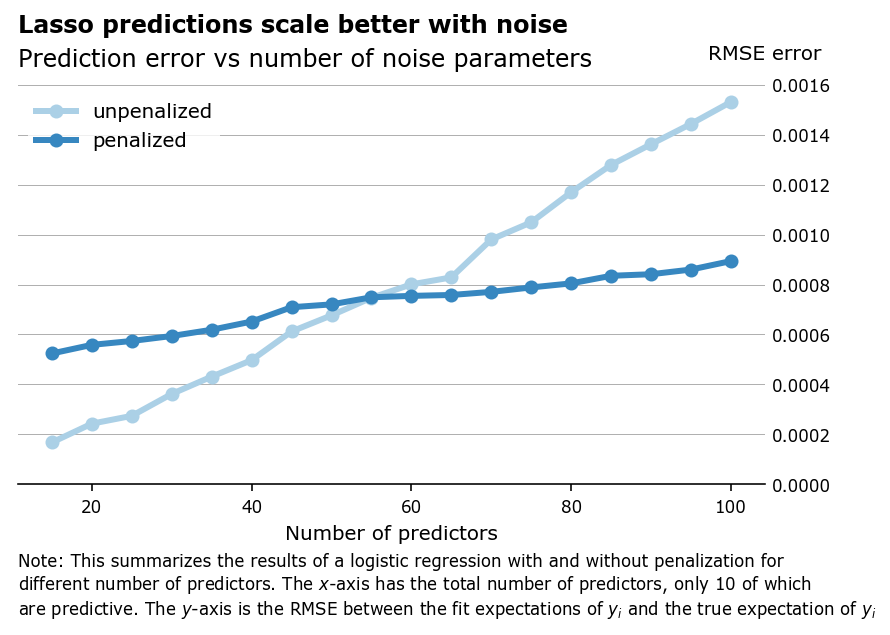

In [243]:
with sns.color_palette('Blues', 2):
    dat = results.pivot(index='p', columns='lam', values='y_rmse')
    plt.plot(dat[1e-20], 'o-', label='unpenalized')
    plt.plot(dat[3e5], 'o-', label='penalized')
plt.legend()
plt.ylim(ymin=0)
plt.ylabel('RMSE error')
plt.xlabel('Number of predictors')
artists = ft_ax(title='Lasso predictions scale better with noise', 
      subtitle='Prediction error vs number of noise parameters', 
      y=1.1,
      source='Note: This summarizes the results of a logistic regression with ' +
          'and without penalization for\ndifferent number of predictors. The $x$-axis '
          'has the total number of predictors, only 10 of which\nare predictive. The ' + 
          '$y$-axis is the RMSE between the fit expectations of $y_i$ and the true ' + 
          'expectation of $y_i$')

plt.savefig('report/figs/lasso-pred-error.pdf', bbox_inches='tight', bbox_extra_artists=artists)

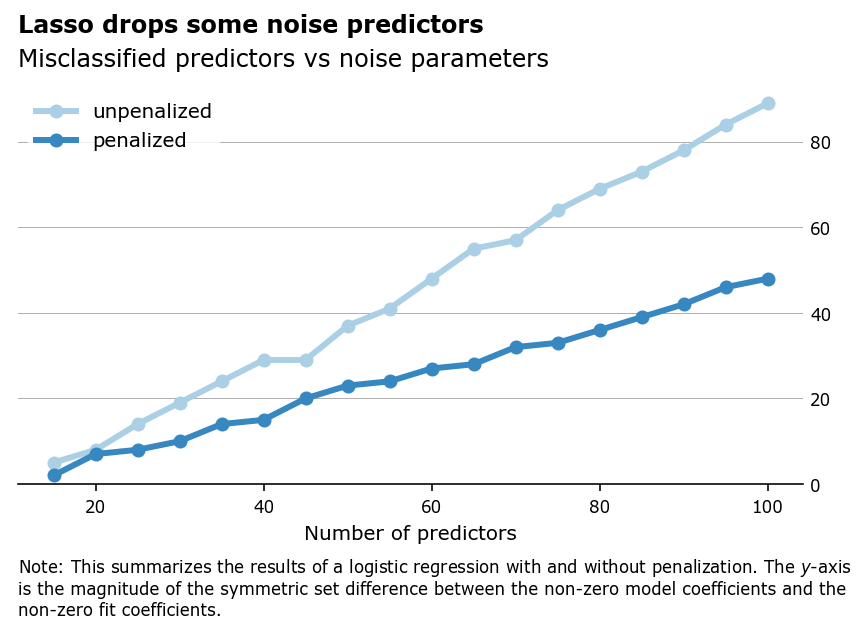

In [241]:
# darker is more regularized
with sns.color_palette('Blues', 2):
    dat = results.pivot(index='p', columns='lam', values='symm_diff')
    plt.plot(dat[1e-20], 'o-', label='unpenalized')
    plt.plot(dat[3e5], 'o-', label='penalized')
plt.legend()
plt.ylim(ymin=0)
plt.xlabel('Number of predictors')
artists = ft_ax(title='Lasso drops some noise predictors', 
      subtitle='Misclassified predictors vs noise parameters', 
      y=1.1,
      source='Note: This summarizes the results of a logistic regression with ' + 
         'and without penalization. The $y$-axis\nis the magnitude of the symmetric ' +
         'set difference between the non-zero model coefficients and the\nnon-zero fit ' + 
         'coefficients.')

plt.savefig('report/figs/lasso-symm-diff.pdf', bbox_inches='tight', bbox_extra_artists=artists)